In [1]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline
plt.style.use("ggplot")

# Feature importances for WATExR

Estimating feature importances using a Random Forest, for dependent variable growing season maximum lake cyanobacteria biovolume.

## Read data

In [2]:
# Variable of interest. Choose from 'TP', 'Chl-a', 'CyanoBiovol'. These need to match the data matrix file names
variable = "CyanoBiovol"

# Dict to translate from variable name used in filename, to that used in column name for picking out target var
target_var_dict = {
    "TP": "tp_lake",
    "Chl-a": "chl-a_lake",
    "CyanoBiovol": "cyanobiovol",
    "colour_lake": "colour_lake",
}

target_var = target_var_dict[variable]

# Read seasonally-aggregated data matrix with target variable and features
in_csv = (
    r"../../Data/DataMatrices/Seasonal_6monthly/split_by_variable/dataMatrix_seasonal_%s_summ_Van2.csv"
    % variable
)
df = pd.read_csv(in_csv)

# Parse dates and tidy
df["Date"] = pd.to_datetime(df["Date"])
df.columns = df.columns.str.lower()
df.set_index("date", inplace=True)

df.head()

,pptn,temp,wind_speed,q,tp_catch,chl-a_lake,tp_lake,colour_lake,cyanobiovol,rain_day,...,pptn_intense_lag1,wind_under_q0.2_lag1,wind_under_q0.4_lag1,wind_over_q0.6_lag1,wind_over_q0.8_lag1,tp_lake_prevsummer,colour_lake_prevsummer,chl-a_lake_prevsummer,temp_prevsummer,cyanobiovol_prevsummer
date,,,,,,,,,,,,,,,,,,,,,
1996-10-31,458.782144,12.502697,3.524457,50.767517,107.784000,21.300000,31.283333,17.666667,4.80,57.0,...,2.0,87.0,128.0,26.0,10.0,29.450000,25.833333,21.883333,13.361027,NaN
1997-10-31,420.414230,13.631344,3.231522,26.853120,45.546154,23.066667,29.416667,19.000000,2.82,55.0,...,12.0,49.0,73.0,76.0,46.0,31.283333,17.666667,21.300000,12.502697,4.80
1998-10-31,520.147169,12.169185,3.488587,54.536026,65.750000,21.100000,32.366667,NaN,2.28,77.0,...,12.0,45.0,86.0,63.0,28.0,29.416667,19.000000,23.066667,13.631344,2.82
1999-10-31,636.833939,12.947504,3.530978,73.483200,99.400000,NaN,NaN,50.423077,5.96,71.0,...,19.0,54.0,96.0,54.0,39.0,32.366667,NaN,21.100000,12.169185,2.28
2000-10-31,621.651733,13.053145,3.611413,60.662131,64.111111,22.166667,32.666667,42.560000,4.67,77.0,...,10.0,36.0,72.0,69.0,45.0,NaN,50.423077,NaN,12.947504,5.96


# Filling missing data

Most ML algorithms don't like missing data. The code below calculates the proportion of missing values in each column.

In [3]:
# Pct missing
missing = pd.DataFrame(df.isnull().sum()).rename(columns={0: "total"})
missing["percent"] = 100 * missing["total"] / len(df)
missing.sort_values("percent", ascending=False).head(10)

,total,percent
tp_catch,2,8.695652
cyanobiovol_prevsummer,1,4.347826
tp_lake,1,4.347826
tp_lake_prevsummer,1,4.347826
colour_lake,1,4.347826
colour_lake_prevsummer,1,4.347826
chl-a_lake,1,4.347826
chl-a_lake_prevsummer,1,4.347826
wind_speed_lag1,0,0.000000
temp_prevsummer,0,0.000000


In [4]:
df.columns

Index(['pptn', 'temp', 'wind_speed', 'q', 'tp_catch', 'chl-a_lake', 'tp_lake',
       'colour_lake', 'cyanobiovol', 'rain_day', 'pptn_intense',
       'wind_under_q0.2', 'wind_under_q0.4', 'wind_over_q0.6',
       'wind_over_q0.8', 'season', 'pptn_lag1', 'temp_lag1', 'wind_speed_lag1',
       'q_lag1', 'rain_day_lag1', 'pptn_intense_lag1', 'wind_under_q0.2_lag1',
       'wind_under_q0.4_lag1', 'wind_over_q0.6_lag1', 'wind_over_q0.8_lag1',
       'tp_lake_prevsummer', 'colour_lake_prevsummer', 'chl-a_lake_prevsummer',
       'temp_prevsummer', 'cyanobiovol_prevsummer'],
      dtype='object')

To fill the gaps:
Forward or backfill at the start/end of the period if there is just one missing row, interpolate if there's just one gap, and otherwise fill with the median for the variable.

**Note:** Filling NaNs in this way transfers information between samples (i.e. rows) in the dataset. This violates the assumption that each row can be treated as an independent sample and may bias the model evaluation performed below. Ideally, we would retain a completely independent testing dataset for final model evaluation, but we don't have enough data for that here.

In [5]:
# Drop some features. Take opportunity to dropp season column here too.
drop_features = ["season"]
df = df.drop(drop_features, axis=1)

# Patch missing values in other rows

# Linearly interpolate gaps of size 1
df.interpolate(method="linear", limit=1, inplace=True)

# Backwards fill a couple of features with one missing row at start of record
for col in ["colour_lake", "colour_lake_prevsummer", "cyanobiovol_prevsummer"]:
    df[col] = df[col].fillna(method="bfill", limit=2)

# For discharge and tp_catch, which have slightly larger gaps, fill with the median over the whole series
for col in ["q", "tp_catch"]:
    df[col] = df[col].fillna(df[col].median())

How effective has this startegy been at filling NaNs?

In [6]:
# Pct missing
missing = pd.DataFrame(df.isnull().sum()).rename(columns={0: "total"})
missing["percent"] = 100 * missing["total"] / len(df)
missing.sort_values("percent", ascending=False).head(10)

,total,percent
pptn,0,0.0
temp,0,0.0
temp_prevsummer,0,0.0
chl-a_lake_prevsummer,0,0.0
colour_lake_prevsummer,0,0.0
tp_lake_prevsummer,0,0.0
wind_over_q0.8_lag1,0,0.0
wind_over_q0.6_lag1,0,0.0
wind_under_q0.4_lag1,0,0.0
wind_under_q0.2_lag1,0,0.0


In [7]:
# df.plot(subplots=True, figsize=(15,20));

# Random forest modelling

## Drop any remaining NaNs

In [8]:
df2 = df.dropna(how='any')
print('Length of original dataset:', len(df))
print('Length of trimmed dataset: ', len(df2))

Length of original dataset: 23
Length of trimmed dataset:  23


In [9]:
# Define response vars (target variable defined at the start)
exp_vars = [i for i in df2.columns if i != target_var]

# Extract vars
y = df2[target_var]
X = df2[exp_vars]

# Standardise exp vars
scalar = StandardScaler()
X_scaled = pd.DataFrame(scalar.fit_transform(X), index=X.index, columns=X.columns)

print("Number of features:%s" % len(exp_vars))

Number of features:29


## Fit model

Random Forests use "bootstrapping" to partition the data used by each tree. Data not included in each bootstrap sample can therefore be used to perform "internal" validation, without the need for a holdout dataset as is usual for cross-validation. This approach is usually referred to as the "out-of-bag" (OOB) validation score. In sci-kit learn, this is roughly equivalent to $R^2$, but calculated on "unseen" data (as opposed to the less stringent "within-sample" $R^2$ typically reported for OLS regression).

OOB scores are not *exactly* the same as cross-validation but, under typical circumstances, the OOB score should be roughly comparable to 3-fold CV (see e.g. [here](https://stats.stackexchange.com/a/199201/5467) and [here](https://stats.stackexchange.com/a/208018/5467) for some discussion). When using OOB scores, it is not necessary to split the data into training and testing sets, which is a big advantage when data are limited (as is the case here). Ideally, validation using a test set should also be performed, but for the work here I'm going to focus on OOB scores in order to make the most of limited data.

Random Forests have a number of hyperparameters that can be tuned to improve performance. Of these, the most important seem to be `'n_estimators'` (the number of treesin the forest) and `'max_features'` (the size of the random subsets of features to consider when splitting a node). There is some debate about the best values to choose for `'max_features'`: the default for regression problems in sci-kit learn is `'max_features' = 'n_features'`, whereas in R the recommended value is to use about one third of the total number of features (see the comments on [this](https://stackoverflow.com/a/23950648/505698) post and the references in the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) for details).

The code below (modified from [here](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html)) plots the OOB error rate (= `1 - OOB_Score`) as a function of `'n_estimators'` for various choices for `'max_features'`. 

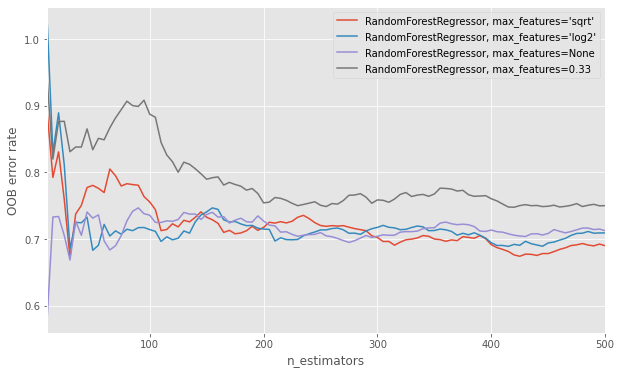

In [10]:
# For reproducibility
rand_state = 42

# List classifiers of interest
# NB: Setting the `warm_start=True` disables parallel support, but is necessary for
# tracking the OOB error trajectory during training
ensemble_clfs = [
    (
        "RandomForestRegressor, max_features='sqrt'",
        RandomForestRegressor(
            n_estimators=100,
            warm_start=True,
            oob_score=True,
            max_features="sqrt",
            random_state=rand_state,
        ),
    ),
    (
        "RandomForestRegressor, max_features='log2'",
        RandomForestRegressor(
            n_estimators=100,
            warm_start=True,
            max_features="log2",
            oob_score=True,
            random_state=rand_state,
        ),
    ),
    (
        "RandomForestRegressor, max_features=None",
        RandomForestRegressor(
            n_estimators=100,
            warm_start=True,
            max_features=None,  # Default. Uses all feats
            oob_score=True,
            random_state=rand_state,
        ),
    ),
    (
        "RandomForestRegressor, max_features=0.33",
        RandomForestRegressor(
            n_estimators=100,
            warm_start=True,
            max_features=0.33,  # Older recommendation. Used by R
            oob_score=True,
            random_state=rand_state,
        ),
    ),
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore
min_estimators = 10
max_estimators = 500

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(X_scaled, y)

        # Record the OOB error
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot
fig = plt.figure(figsize=(10, 6))
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")

To pick the best parameters to use in the models below, pick the curve in the above plot which has the lowest error rate, and pick n_estimators where the curve has flattened out or reached a minimum.

## Feature importances

In [15]:
# Set based on graph above
n_estimators = 430
max_features = "sqrt"

# Build model using 'best' results from above
model = RandomForestRegressor(
    n_estimators=n_estimators,
    warm_start=False,
    max_features=max_features,
    oob_score=True,
    random_state=rand_state,
)
model.fit(X_scaled, y)

print("OOB score: %.2f" % model.oob_score_)

# Get importance scores
res_df = pd.DataFrame(
    {"importance": model.feature_importances_}, index=X.columns.values
).sort_values(by="importance", ascending=False)
res_df.head(10)

OOB score: 0.32


,importance
chl-a_lake,0.126532
colour_lake_prevsummer,0.089471
cyanobiovol_prevsummer,0.082540
chl-a_lake_prevsummer,0.079370
tp_lake,0.067679
tp_lake_prevsummer,0.064670
colour_lake,0.048675
tp_catch,0.047555
wind_over_q0.6_lag1,0.037016
temp_prevsummer,0.032196


Looking at effect of choice of params: Seems pretty robust.

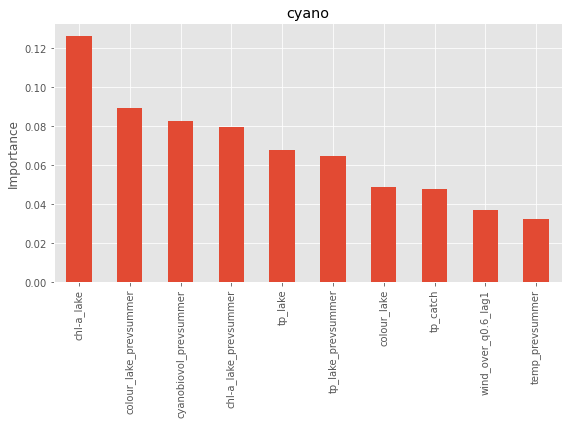

In [16]:
# Plot top 10 feature importances
ax = res_df[:10].plot(kind='bar', figsize=(8,6))
plt.ylabel('Importance')
ax.get_legend().remove()
plt.title('cyano');
plt.tight_layout()
plt.savefig('../../Figures/FeatureImportance/cyano.png')

# Recursive feature elimination

Recursive feature elimination attempts to find the best model using subsets of the available features. This is essentially the same as "stepwise" regression, except here we're using CV to avoid overfitting (as opposed to traditional "significance testing"). In the code below, I've used out-of-sample $R^2$ as a measure of performance. The best values obtained are pretty low, but remember that out-of-sample tests are much more stringent than their within-sample equivalents. The best overall indicator of perfornmance used in this notebook is the OOB score.

**Note:** Other scoring metrics are available. Use 

    sorted(sklearn.metrics.SCORERS.keys())
    
to print a list.

Optimal number of features: 1

Optimal features (in no particular order):
   chl-a_lake


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


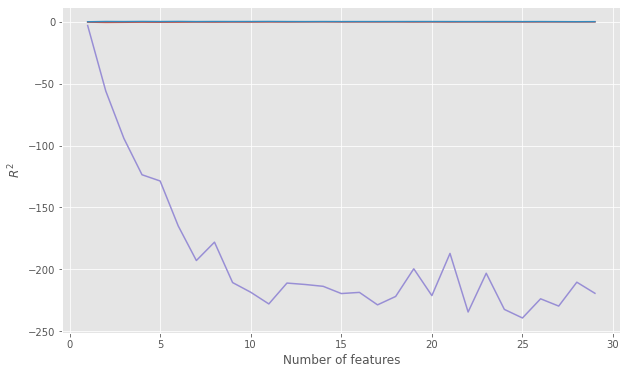

In [12]:
# Build same model as above
model = RandomForestRegressor(
    n_estimators=n_estimators,
    warm_start=False,
    max_features=max_features,
    oob_score=True,
    random_state=rand_state,
)

# Feature elimination with 3-fold CV
rfecv = RFECV(estimator=model, step=1, cv=3, scoring="r2", n_jobs=-1)

selector = rfecv.fit(X_scaled, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print("")
print("Optimal features (in no particular order):")
for i in np.array(exp_vars)[selector.support_]:
    print("  ", i)

# Plot number of features vs. cross-validation score
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features")
plt.ylabel("$R^2$")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

Use the plot to decide roughly how many features to pick before things level off.

**Find:** Best performance with just one feature (chl-a), decreasing thereafter. But results look dodgy.

In [14]:
# Reduce list of exp vars based on results above
exp_vars_2 = [
    "chl-a_lake",   # Optimum
    "colour_lake",  # Proposed for BN
]

# Extract vars
y = df2[target_var]
X2 = df2[exp_vars_2]

# Standardise exp vars
scalar = StandardScaler()
X2_scaled = pd.DataFrame(scalar.fit_transform(X2), index=X2.index, columns=X2.columns)

# Build model using 'best' results from above
model = RandomForestRegressor(
    n_estimators=n_estimators,
    warm_start=False,
    max_features=max_features,
    oob_score=True,
    random_state=rand_state,
)
model.fit(X2_scaled, y)

print("OOB score: %.2f" % model.oob_score_)

# Get importance scores
res_df = pd.DataFrame(
    {"importance": model.feature_importances_}, index=X2.columns.values
).sort_values(by="importance", ascending=False)
res_df.head(10)

OOB score: 0.51


,importance
chl-a_lake,0.628761
colour_lake,0.371239


**Comments**

- Recursive feature elimination: Optimal features just 1, chl-a_lake. Big drop of after that to 2, 3, then levelling off after about 6 at a low.
- OOB using just chl-a_lake: 0.35.
- If add in anything colour-related, e.g. colour_prevsummer: OOB increases to 0.53, and both are important (chl-a_lake 0.55, colour_lake_prevsummer 0.45). i.e. better than when use all features.
- Use current season’s colour instead of previous season’s colour, and chl-a: OOB 0.54. i.e. a bit better!
- Try adding in any weather variables, e.g. temp: OOB 0.45 (worse, and temp importance lower than colour_lake), wind_under_q0.2 (same OOB of 0.54, wind importance 0.24, colour_lake 0.3, chl-a_lake 0.46).

<AxesSubplot:>

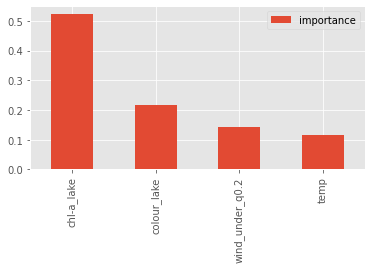

In [58]:
# Plot
res_df[:15].plot(kind="bar", figsize=(6, 3))